###  Example on coupled Kuramoto oscillators

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.signal import hilbert
from tqdm import tqdm
from mne.time_frequency.tfr import tfr_array_morlet
from frites.core import gcmi_nd_cc

### Function to run Kuramoto simulation

In [101]:
def Kuramoto_Delays_Run_timevar(
    C: list, D: list, f: float, fs: float, icoup, K, MD, npoints
):
    """
    Function to run simulations of coupled systems using the
    Kuramodo model of coupled oscillators with time delays.

    - Each node is represented by a Phase oscillators
    - with natural frequency f
    - coupling according to a connectivity matrix C
    - with a distance matrix D (scaled to delays by the mean delay MD)

    All units in Seconds, Meters, Hz.
    """

    ### Model parameters

    dt = 0.05 / fs # Resolution of the model integation in seconds
    noise = 3.5

    ### Normalize parameters
    N = C.shape[0]  # Number of units
    Omegas = (
        2 * np.pi * f * np.ones(N) * dt
    )  #  Frequency of all units in radians / second
    kC = K * C * dt  #  Scale matrix C with K and dt to avoid doing it at each step
    dsig = np.sqrt(dt) * noise  # Normailize std of noise with dt

    # Set a matrix of delays containig the number of time-steps between nodes
    # Delays are integer numbers, so make sure the dt is much smaller than the
    # smallest delay.
    if MD == 0:
        Delays = np.zeros((N, N)).astype(int)
    else:
        mean_D = D.flatten()
        mean_D = mean_D[mean_D > 0].mean()
        Delays = (round((D / mean_D * MD) / dt)).astype(int)
    Delays = Delays * (C > 0)

    Max_History = int(np.max(Delays) + 1)

    # Revert the Delays matrix such that it contains the index of the History
    # that we need to retrieve at each dt

    ## Initialization

    # History of Phases is needed at dt resolution for as long as the longest
    # delay. The system is initialized all desinchronized and uncoupled
    # oscillating at their natural frequencies

    Phases_History = 2 * np.pi * np.random.rand(N) + Omegas * np.ones(
        (N, Max_History)
    ) * np.arange(1, Max_History + 1)

    Phases_History = Phases_History % (2 * np.pi)

    # This History matrix will be continuously updated (sliding history)

    # Simulated activity will be saved only at dt_save resolution
    Phases = np.zeros((N, npoints))
    sumz = np.zeros(N)

    for t in range(npoints):
        Phase_Now = Phases_History[:, -1].copy()

        # Input from coupled units
        for n in range(N):
            sumzn = 0  #  Initialize total coupling received into node n
            for p in range(N):
                if kC[n, p]:
                    sumzn = sumzn + icoup[t] * kC[n, p]
                    sumzn = sumzn * np.sin(
                        Phases_History[p, Delays[n, p]] - Phase_Now[n]
                    )
            sumz[n] = sumzn

        if MD > 0:  # Slide history only if delays are greather than zero
            Phases_History[:, :-1] = Phases_History[:, 1:]

        Phases_History[:, -1] = (
            Phase_Now + Omegas + sumz + dsig * np.random.normal(0, 1, size=N)
        )

        Phases[:, t] = Phases_History[:, -1]

    Fourier = np.fft.fft(np.sin(Phases), n=npoints, axis=1)
    TS = np.real(np.fft.ifft(Fourier))

    return TS, Phases

### Simulated data

In [102]:
# Parameters
ntrials = 500
fsamp = 600
time = np.arange(-0.5, 1, 1 / fsamp)
Npoints = len(time)
C = np.array([[0, 1, 0], [0, 0, 1], [0, 0, 0]]).T
data = np.zeros((C.shape[1], ntrials, Npoints))
datah = np.zeros((C.shape[1], ntrials, Npoints), dtype=complex)

# Derived parameters
N = C.shape[0]
D = np.ones((N, N)) / 1000  # Fixed delay matrix divided by 1000
C = C / np.mean(C[np.ones((N, N)) - np.eye(N) > 0])
f = 40  # Node natural frequency in Hz
MD = 0.0  # Mean Delay in seconds
K = 10  # Global coupling strength
s = 8 / (2 * np.pi * f)

# Coupling time window
time_start = 0
time_end = 0.4
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(1, 100, ntrials)

# Placeholder simulation loop with random data
for itrials in tqdm(range(ntrials)):
    # Generate random placeholder data for TS with shape (3, Npoints)
    TS, dt_save = Kuramoto_Delays_Run_timevar(
        C, D, f, fsamp, CS[itrials] * coupling, K, MD, Npoints
    )

    # Extract time series data
    x, y, z = TS[0], TS[1], TS[2]
    data[0, itrials, :] = x
    data[1, itrials, :] = y
    data[2, itrials, :] = z

    # Apply Hilbert transform
    datah[0, itrials, :] = hilbert(x)
    datah[1, itrials, :] = hilbert(y)
    datah[2, itrials, :] = hilbert(z)

# Output the shapes of data and datah for verification
data.shape, datah.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 110.68it/s]


((3, 500, 900), (3, 500, 900))

In [103]:
data = xr.DataArray(
    data.transpose(1, 0, 2),
    dims=("trials", "roi", "times"),
    coords=(CS, range(3), time),
)

### Measuring stimulus-specific information

In [107]:
freqs = np.linspace(10, 100, 50)

W = tfr_array_morlet(
    data.values,
    fsamp,
    freqs,
    7,
    output="complex",
    n_jobs=10,
    zero_mean=False,
)

W = xr.DataArray(
    W,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values},
)

ValueError: At least one of the wavelets is longer than the signal. Use a longer signal or shorter wavelets.

In [84]:
power_amplitude = np.abs(W)
complex_phase = W / power_amplitude
complex_phase_diff = complex_phase.isel(roi=0) * np.conj(complex_phase.isel(roi=2))


power_edge = np.stack(
    (power_amplitude.isel(roi=0), power_amplitude.isel(roi=1)), axis=1
)
phase_edge = np.stack((complex_phase_diff.real, complex_phase_diff.imag), axis=1)

power_phase_edge = np.stack(
    (
        power_amplitude.isel(roi=0),
        power_amplitude.isel(roi=1),
        complex_phase_diff.real,
        complex_phase_diff.imag,
    ),
    axis=1,
)

In [85]:
stim = data.trials.values
stim = np.expand_dims(stim, axis=(0, 1))
stim = np.tile(stim, (len(freqs), W.sizes["times"], 1, 1)).transpose(3, 2, 0, 1)

In [86]:
power_encoding = gcmi_nd_cc(power_edge, stim, mvaxis=1, traxis=0)
phase_encoding = gcmi_nd_cc(phase_edge, stim, mvaxis=1, traxis=0)
power_phase_encoding = gcmi_nd_cc(power_phase_edge, stim, mvaxis=1, traxis=0)

In [87]:
# Redundancy
red = np.minimum(phase_encoding, power_encoding)

# Uniques
unique_power = power_encoding - red
unique_phase = phase_encoding - red

# Synergy
syn = power_phase_encoding - unique_power - unique_phase - red

In [88]:
"""
power_encoding_surr = []
phase_encoding_surr = []

_stim = np.stack([1] * 100 + [2] * 100 + [3] * 100)

for i in tqdm(range(100)):
    np.random.shuffle(_stim)
    power_encoding_surr += [gcmi_model_nd_cd(power_edge, _stim, mvaxis=1, traxis=0)]
    phase_encoding_surr += [gcmi_model_nd_cd(phase_edge, _stim, mvaxis=1, traxis=0)]
""";

In [89]:
power_encoding = xr.DataArray(
    power_encoding,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="power encoding [bits]",
).squeeze()

phase_encoding = xr.DataArray(
    phase_encoding,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

unique_power = xr.DataArray(
    unique_power,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

unique_phase = xr.DataArray(
    unique_phase,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

syn = xr.DataArray(
    syn,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

red = xr.DataArray(
    red,
    dims=("freqs", "times"),
    coords=(freqs, W.times.values),
    name="phase encoding [bits]",
).squeeze()

Text(0.5, 1.0, 'Phase only')

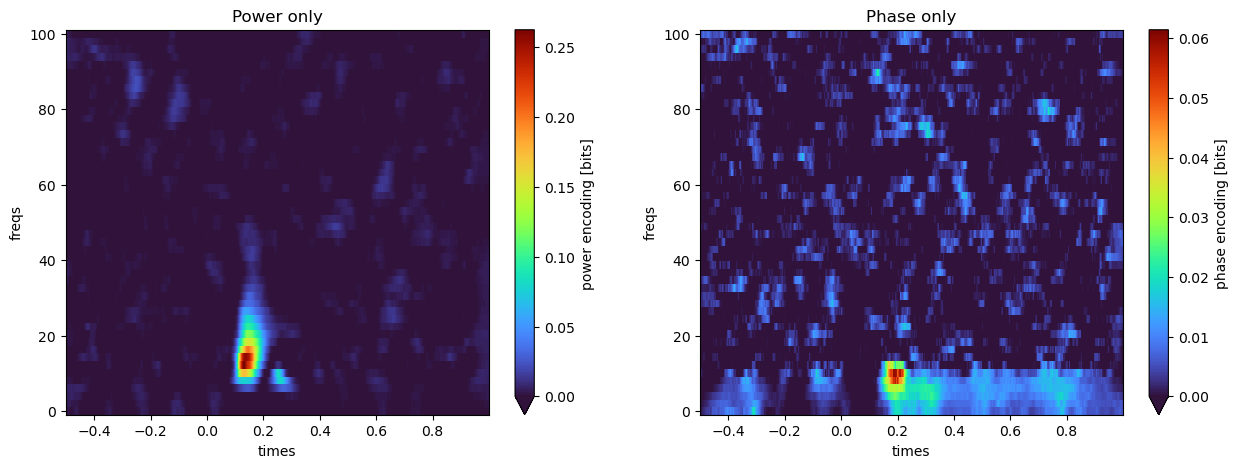

In [91]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
power_encoding.plot.imshow(cmap="turbo", vmin=0)
plt.title("Power only")
plt.subplot(122)
phase_encoding.plot.imshow(cmap="turbo", vmin=0)
plt.title("Phase only")

Text(0.5, 1.0, 'Synergy')

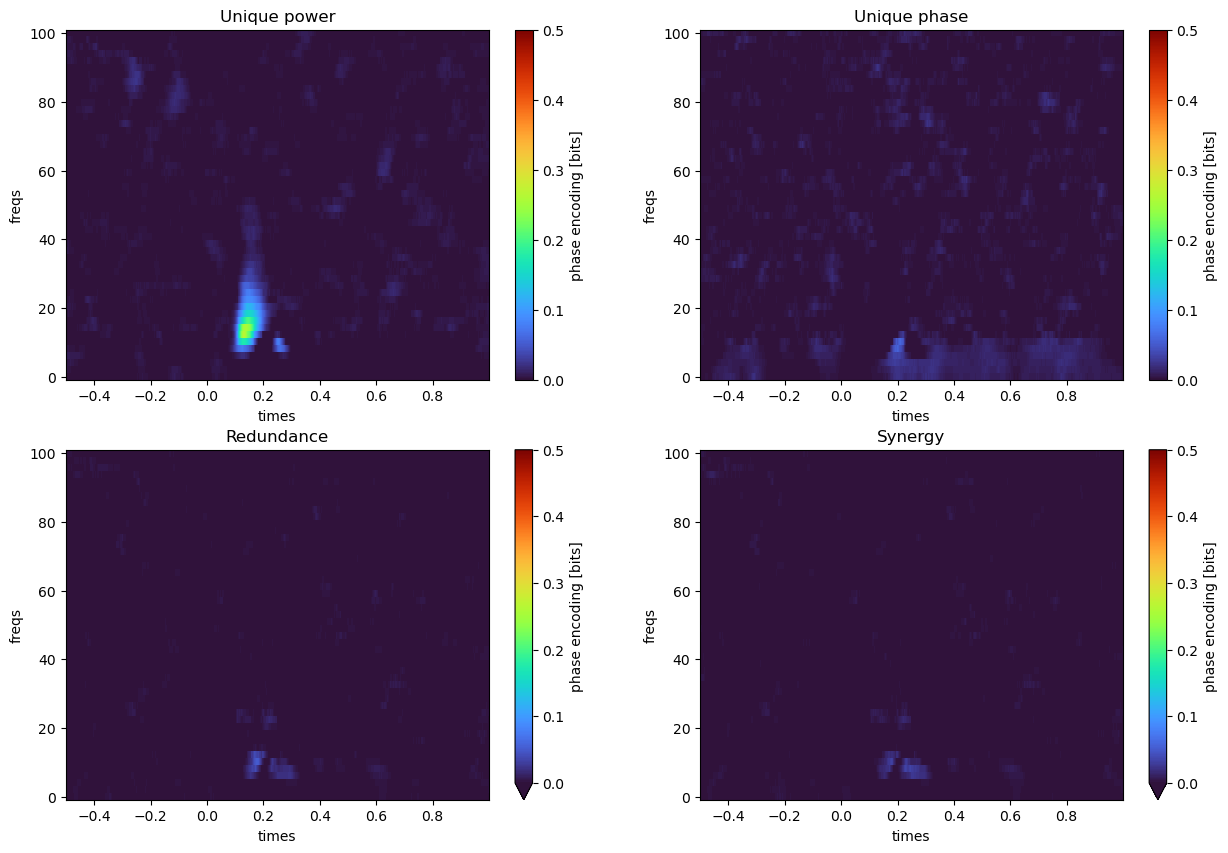

In [92]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
unique_power.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Unique power")
plt.subplot(222)
unique_phase.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Unique phase")
plt.subplot(223)
red.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Redundance")
plt.subplot(224)
syn.plot.imshow(cmap="turbo", vmin=0, vmax=0.5)
plt.title("Synergy")